<a href="https://colab.research.google.com/github/sahar-felehgari/Mask-Detection/blob/main/final_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saharfelegari","key":"a941967b8d2f38e9e767dbfe71c4b844"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d niharika41298/withwithout-mask

 81% 27.0M/33.5M [00:00<00:00, 95.1MB/s]
100% 33.5M/33.5M [00:00<00:00, 95.1MB/s]


In [ ]:
!unzip -qq withwithout-mask.zip

replace maskdata/maskdata/test/with_mask/0-with-mask.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace maskdata/maskdata/test/with_mask/1-with-mask.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os

num_mask_train = len(os.listdir('maskdata/maskdata/train/with_mask'))
num_unmask_train = len(os.listdir('maskdata/maskdata/train/without_mask'))
num_mask_test = len(os.listdir('maskdata/maskdata/test/with_mask'))
num_unmask_test = len(os.listdir('maskdata/maskdata/test/without_mask'))

print(f'Train: with_mask: {num_mask_train} | without_mask: {num_unmask_train}')
print(f'Test: with_mask: {num_unmask_train} | without_mask: {num_unmask_train}')

Train: with_mask: 341 | without_mask: 275
Test: with_mask: 275 | without_mask: 275


In [ ]:
import shutil, pathlib

new_base_dir = pathlib.Path("maskdata")
def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("with_mask", "without_mask"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [ ]:
make_subset("maskdata/maskdata/train", "validation", start_index=10, end_index=100)
num_mask_train = len(os.listdir('maskdata/validation/with_mask'))
num_unmask_train = len(os.listdir('maskdata/validation/without_mask'))
print(f'Train: with_mask validation: {num_mask_train}| without_mask validation: {num_unmask_train}')

Train: with_mask validation: 90| without_mask validation: 90


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'maskdata/train'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=16)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'validation'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'maskdata/test'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=16)

Found 616 files belonging to 2 classes.
Found 180 files belonging to 2 classes.
Found 198 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (16, 180, 180, 3)
labels batch shape: (16, 1)


#model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
    ]

#training

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - 21s 205ms/step - loss: 6.8526 - accuracy: 0.9383 - val_loss: 0.8727 - val_accuracy: 0.9889
Epoch 2/50
39/39 [==============================] - 3s 84ms/step - loss: 2.3532 - accuracy: 0.9805 - val_loss: 1.1127 - val_accuracy: 0.9889
Epoch 3/50
39/39 [==============================] - 3s 85ms/step - loss: 0.6473 - accuracy: 0.9951 - val_loss: 3.0309 - val_accuracy: 0.9833
Epoch 4/50
39/39 [==============================] - 3s 86ms/step - loss: 0.8650 - accuracy: 0.9870 - val_loss: 3.0957 - val_accuracy: 0.9889
Epoch 5/50
39/39 [==============================] - 4s 91ms/step - loss: 1.2034 - accuracy: 0.9903 - val_loss: 0.5908 - val_accuracy: 0.9944
Epoch 6/50
39/39 [==============================] - 3s 86ms/step - loss: 1.0431 - accuracy: 0.9951 - val_loss: 1.5027 - val_accuracy: 0.9944
Epoch 7/50
39/39 [==============================] - 4s 91ms/step - loss: 0.2623 - accuracy: 0.9919 - val_loss: 1.8183e-25 - val_accuracy: 1.0000
Epoch 8

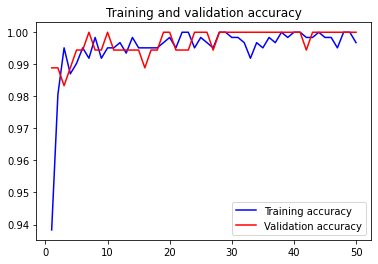

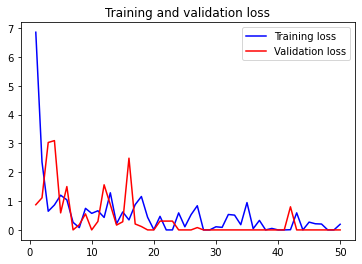

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import files
myfile = files.upload()

Saving maksssksksss6.png to maksssksksss6.png


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = next(iter(myfile))
img = image.load_img(img_path, target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)

In [ ]:
test_model = keras.models.load_model('feature_extraction_with_data_augmentation.keras')
pred = test_model.predict(x)

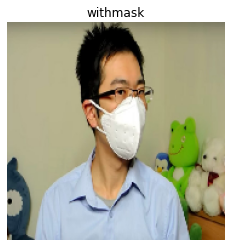

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")
if pred<0.5:
    plt.title('withmask')
else:
    plt.title('withoutmask')